In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
# sns.set(font='SimHei', font_scale=2.5)
# plt.rcParams['axes.grid'] = True

import numpy as np
import pandas as pd

np.random.seed(0)

import logging
logging.basicConfig()
logger = logging.getLogger(__name__)

def show_image(filename, figsize=None, res_dir=False):
    if figsize:
        plt.figure(figsize=figsize)

    if res_dir:
        filename = './res/{}'.format(filename)

    plt.imshow(plt.imread(filename))

Chapter 2: Multi-armed Bandits
==============


### 2.1 A k-armed Bandit Problem

nonassociative, evaluative feedback problem:

reward = sample(P(action))
+ P(action) is a **stationary** probability distribution.
+ reward: $R$
+ $k$ different actions $a$.
+ goal: maximize the expected total reward over some time period.

The value $q$ of $a$ is the expected reward:

\begin{align}
    q(a) &= \mathbb{E} \left [ R_t \mid A_t = a \right ] \\
         &\approx \frac1{N} \sum_t^N R_t \mid A_t = a \quad \text{law of large numbers} \\
         &= Q_t(a)
\end{align}

### 2.2 Action-value Methods

one natural way to estimate the value of $a$ is by averaging the rewards actually received: (sample-average method)
\begin{equation}
    Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}(A_i = a)}{\sum_{i=1}^{t-1} \cdot \mathbb{1}(A_i = a)}
\end{equation}

strategies:
+ greedy action: $A_t = \operatorname{argmax}_a Q_t(a)$
+ $\epsilon$-greedy actions:

\begin{equation}
    A_t =
    \begin{cases}
        \operatorname{argmax}_a Q_t(a) & \quad \text{ with probability 1 - $\epsilon$} \\
        \text{a random action} & \quad \text{ with probability $\epsilon$}
    \end{cases}
\end{equation}

##### Exercise
2.1:

$0.5 * 1 + 0.5 * 1/2 = 0.75$


2.2: 

+ definitely occur: steps = 2, 5
+ possiblly occur: steps= 1, 3, 4

### 2.3 The 10-armed Testbed

In [2]:
reward_funcs = [
    lambda size: np.random.normal(0.2, 1, size),
    lambda size: np.random.normal(-0.8, 1, size),
    lambda size: np.random.normal(1.5, 1, size),
    lambda size: np.random.normal(0.4, 1, size),
    lambda size: np.random.normal(1.2, 1, size),
    lambda size: np.random.normal(-1.3, 1, size),
    lambda size: np.random.normal(-0.2, 1, size),
    lambda size: np.random.normal(-1.0, 1, size),
    lambda size: np.random.normal(1.0, 1, size),
    lambda size: np.random.normal(-0.4, 1, size),
]

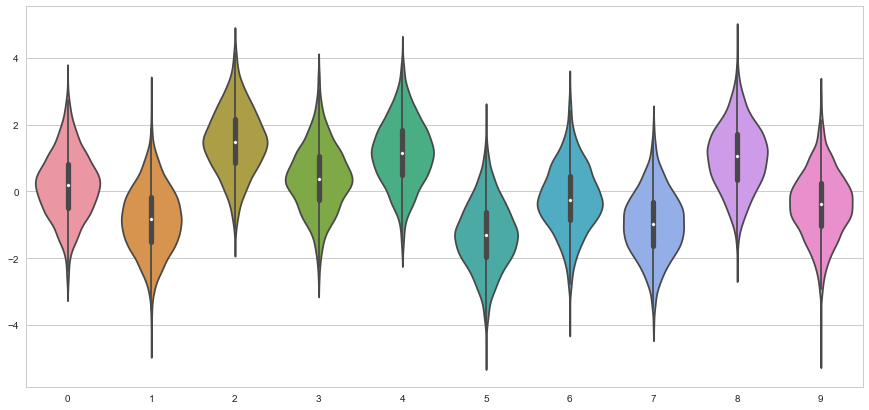

In [3]:
examples = pd.DataFrame([func(2000) for func in reward_funcs]).T
examples.index.name = "Reward distribution"
plt.figure(figsize=(15, 7))
sns.violinplot(data=examples)
del examples

In [4]:
class GreedyAction(object):
    def __init__(self, k, varepsilon=0):
        self.varepsilon = varepsilon
        self.k = k
        # sum of rewards, number of action
        self._records = np.zeros((k, 2))
    
    def _Q_t(self):
        r = self._records[:, 0]
        n = self._records[:, 1]
        res = np.divide(r, n, out=np.zeros_like(r), where=n!=0)
        logger.info("Q_t: {}".format(res))
        return res
    
    def action(self):
        if np.random.random() < self.varepsilon:
            a = np.random.randint(low=0, high=self.k)
            logger.info("random action: {}".format(a))
            return a
        else:
            a = np.argmax(self._Q_t())
            logger.info("greedy action: {}".format(a))
            return a
    
    def update_reward(self, action, reward):
        self._records[action, 0] += reward
        self._records[action, 1] += 1
        
        
class Environment(object):
    def __init__(self, reward_funcs):
        self.reward_funcs = reward_funcs
        self.k = len(reward_funcs)
       
    def feedback(self, action):
        assert 0 <= action < self.k, "action: {} must be in [0, {}]".format(action, self.k)
        return self.reward_funcs[action](1)[0]

In [9]:
def run_10_armed(varepsilon):
    opt_action = 2
    env = Environment(reward_funcs)
    actioner = GreedyAction(env.k, varepsilon)
    step_records = []
    
    def step():
        history = []
        for _ in range(100):
            a = actioner.action()
            r = env.feedback(a)
            actioner.update_reward(a, r)
            logger.info("action: {}, reward: {}".format(a, r))
            history.append([a, r])
        history = np.array(history)
        return np.sum(history[:, 0] == opt_action), np.sum(history[:, 1]), history.shape[0] 
    
    for _ in range(100):
        step_records.append(step())
    
    result = pd.DataFrame(step_records, columns=["opt_actions", "total_rewards", "iterate_nums"])
    result = result.cumsum()
    result["opt_actions_rate"] = result["opt_actions"] / result["iterate_nums"]
    result["average_rewards"] = result["total_rewards"] / result["iterate_nums"]
    # return result[["opt_actions_rate", "average_rewards"]]
    return result

In [6]:
logger.setLevel(logging.WARNING)

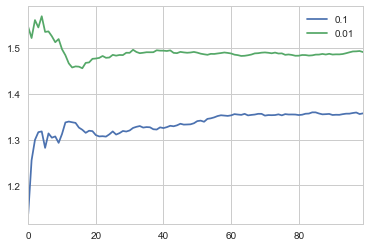

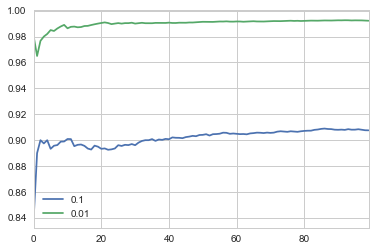

In [15]:
dfs = [run_10_armed(v) for v in [0.1, 0.01]]
results = pd.concat(dfs, keys=['0.1', '0.01'], axis=1).swaplevel(0, 1, axis=1)
results["average_rewards"].plot()
results["opt_actions_rate"].plot()